In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

diabetes_data = pd.read_csv('data/diabetes_data.csv')
display(diabetes_data.head())

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Gender
0,6,98,58,33,190,34.0,0.430,43,0,Female
1,2,112,75,32,0,35.7,0.148,21,0,Female
2,2,108,64,0,0,30.8,0.158,21,0,Female
3,8,107,80,0,0,24.6,0.856,34,0,Female
4,7,136,90,0,0,29.9,0.210,50,0,Female


Предварительно вы можете провести небольшой разведывательный анализ: посмотреть на распределения признаков и оценить их взаимосвязь с признаком наличия диабета.

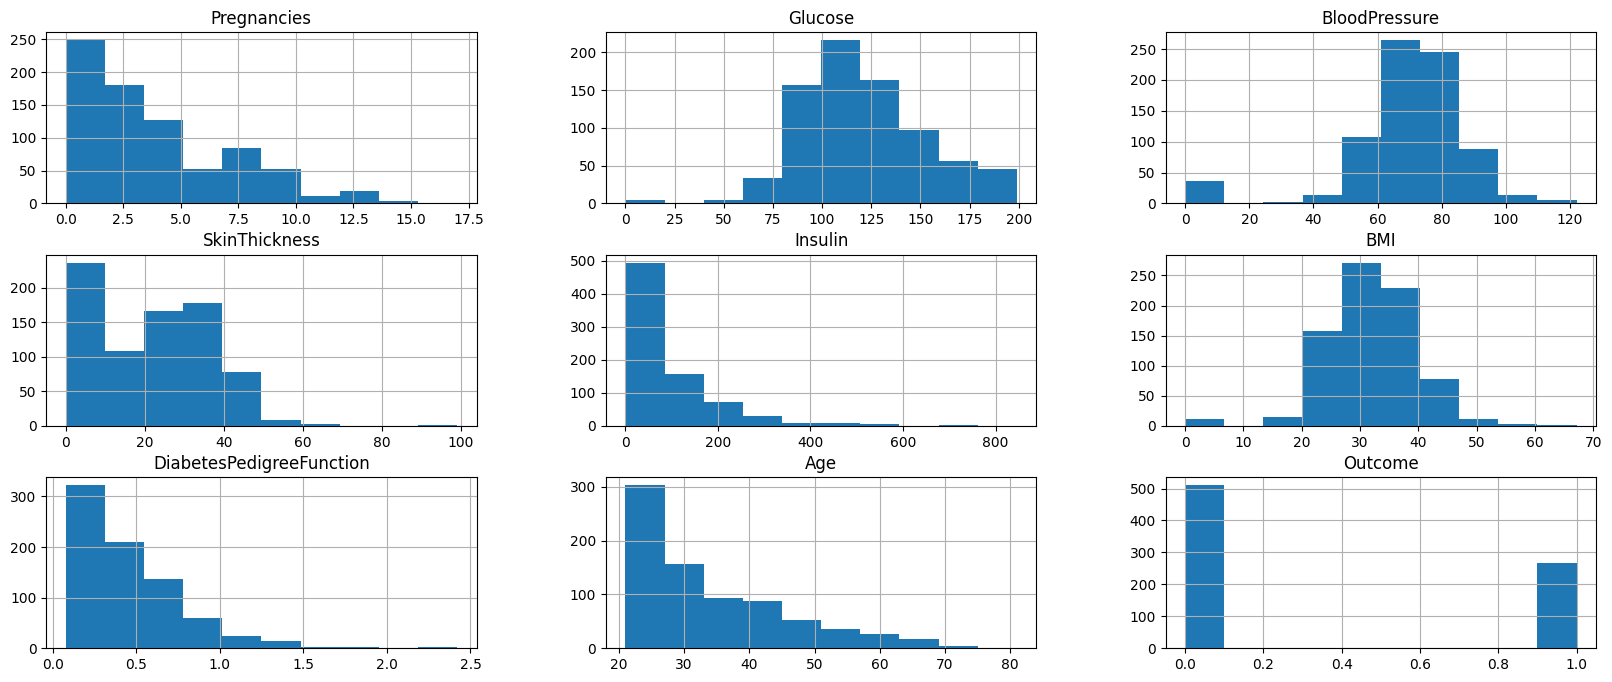

In [29]:
diabetes_data.hist(figsize=(20,8));

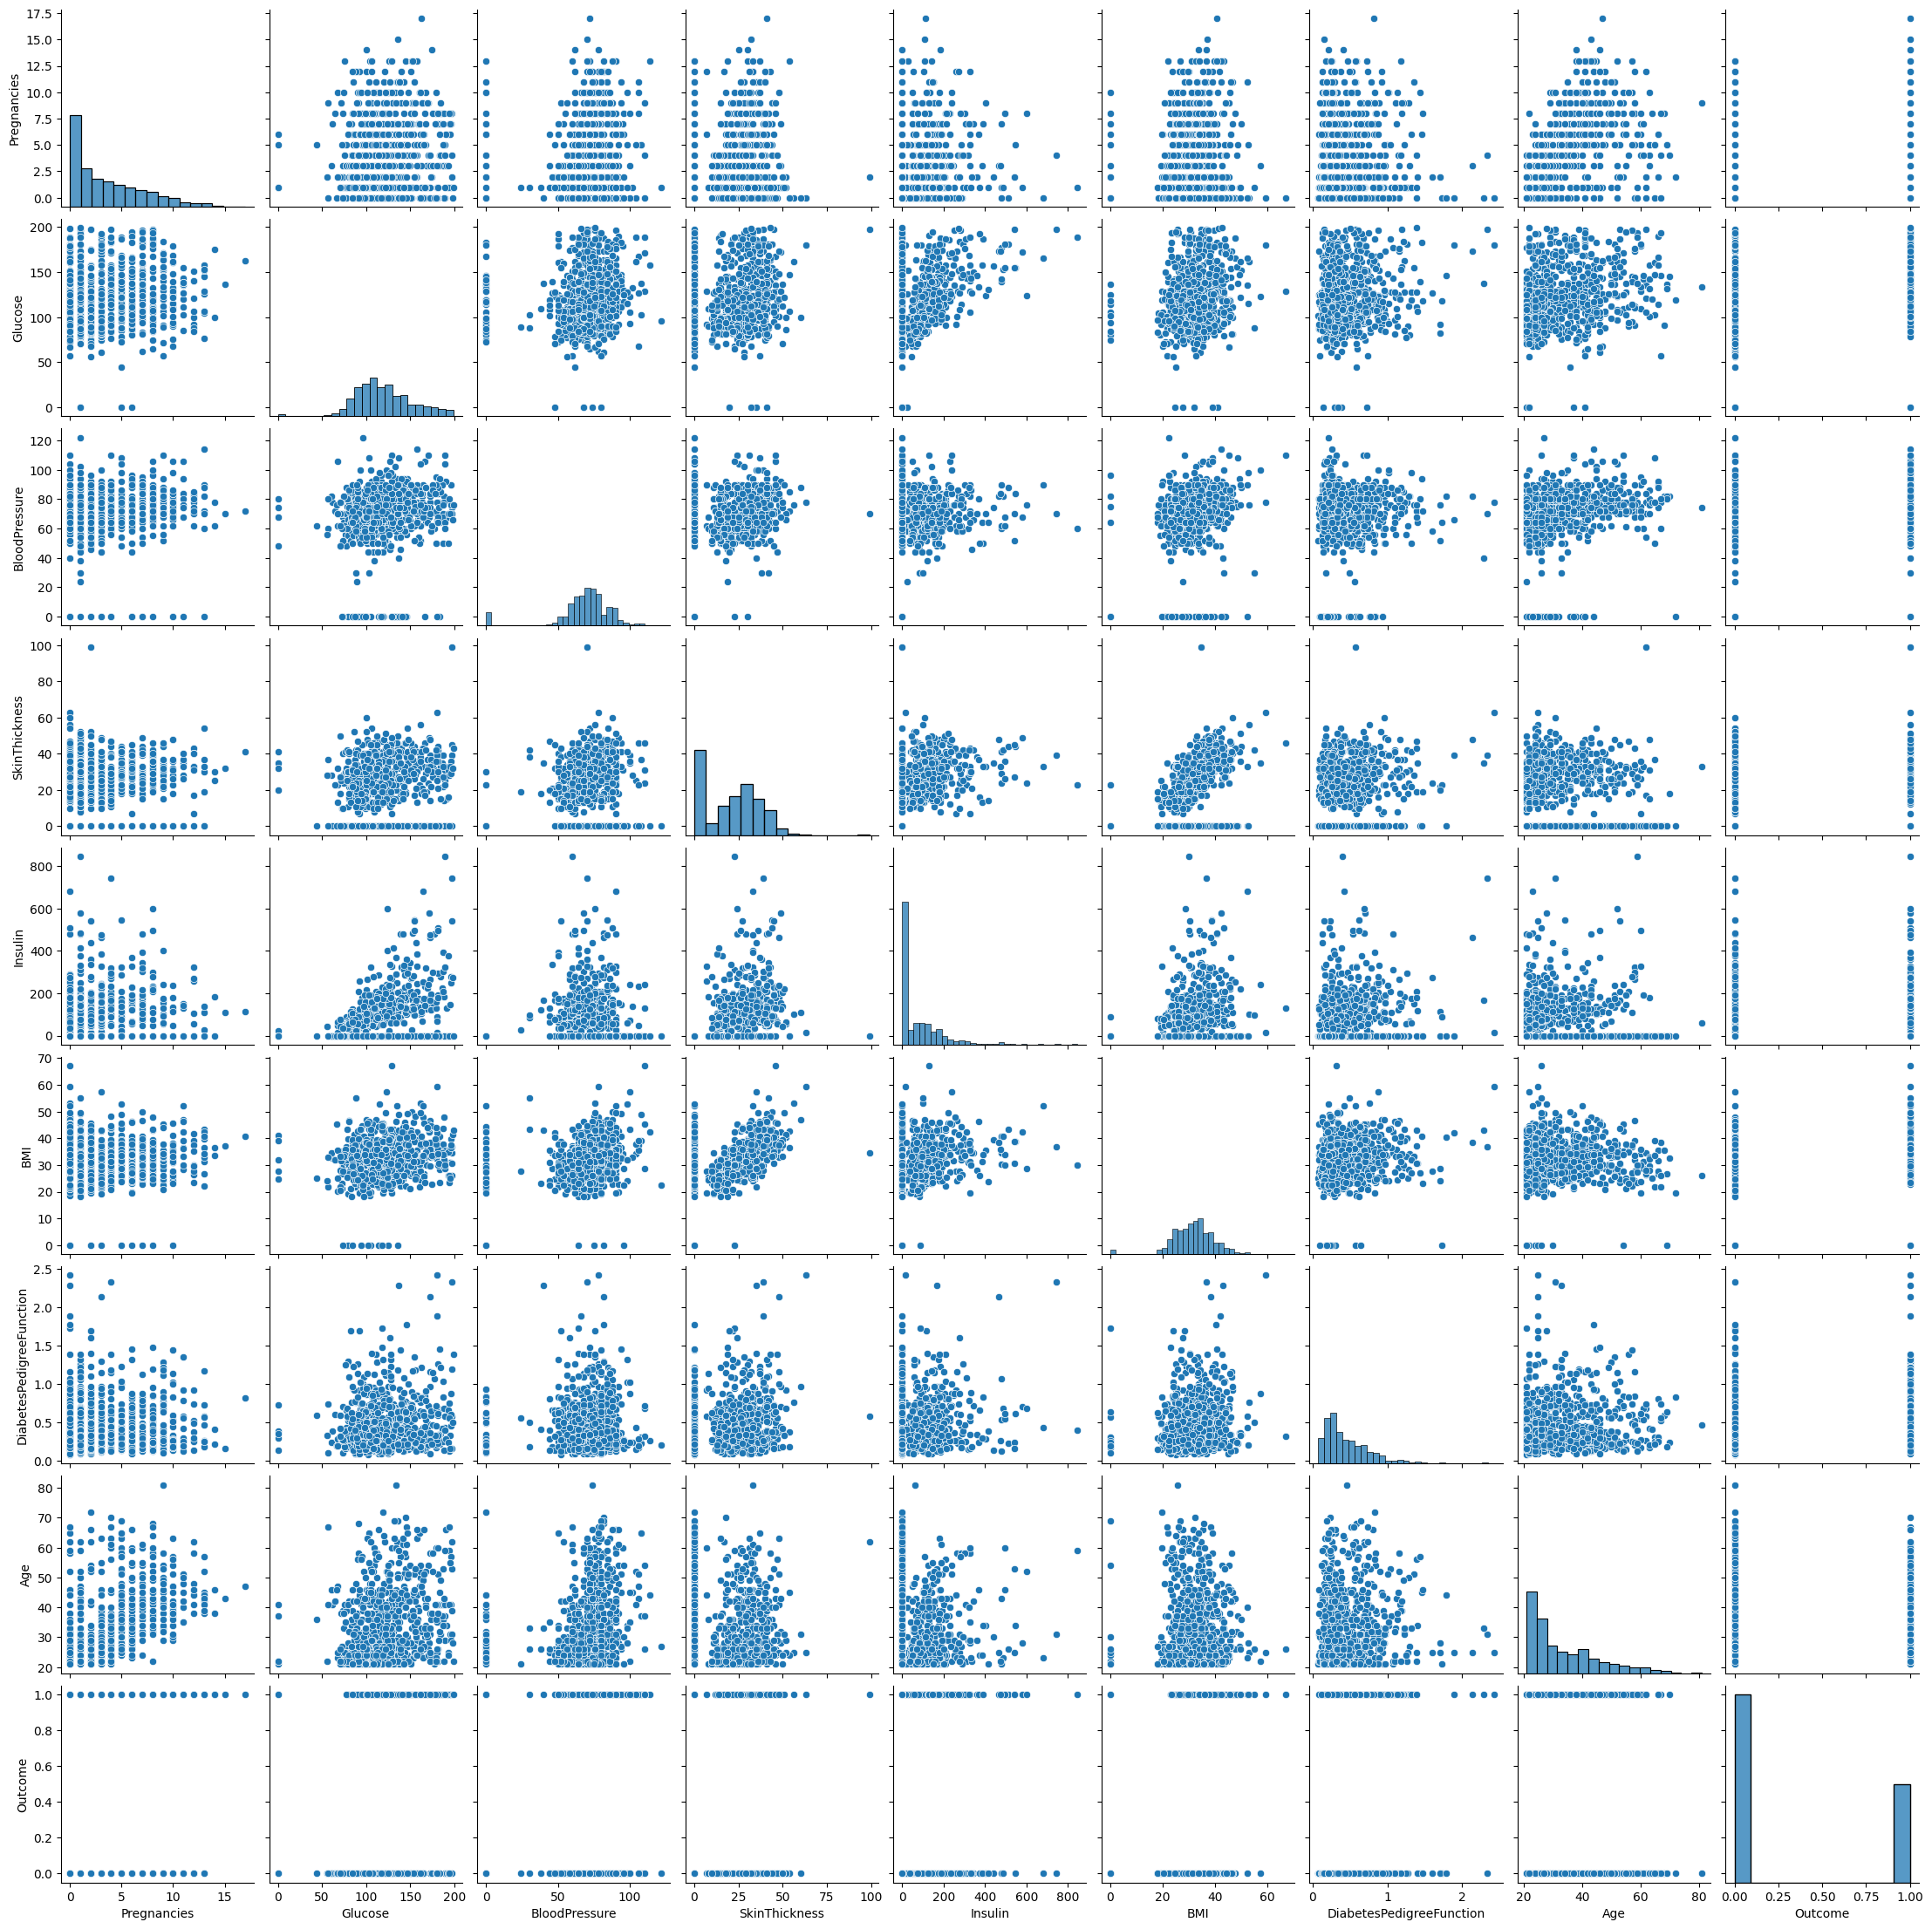

In [30]:
attribute_cols = list(diabetes_data.columns)
attribute_cols.remove('Outcome')

sns.pairplot(diabetes_data);

Начнём с поиска дубликатов в данных. Найдите все повторяющиеся строки в данных и удалите их. Для поиска используйте все признаки в данных. Сколько записей осталось в данных?

In [31]:
mask = diabetes_data.duplicated()
duplicates = diabetes_data[mask]
display(duplicates)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Gender
768,6,98,58,33,190,34.0,0.430,43,0,Female
769,2,112,75,32,0,35.7,0.148,21,0,Female
770,2,108,64,0,0,30.8,0.158,21,0,Female
771,8,107,80,0,0,24.6,0.856,34,0,Female
772,7,136,90,0,0,29.9,0.210,50,0,Female
773,6,103,72,32,190,37.7,0.324,55,0,Female
774,1,71,48,18,76,20.4,0.323,22,0,Female
775,0,117,0,0,0,33.8,0.932,44,0,Female
776,4,154,72,29,126,31.3,0.338,37,0,Female
777,5,147,78,0,0,33.7,0.218,65,0,Female


In [32]:
diabetes_data = diabetes_data.drop_duplicates()
print(f'Resulting number of records: {diabetes_data.shape[0]}')

Resulting number of records: 768


Далее найдите все неинформативные признаки в данных и избавьтесь от них. В качестве порога информативности возьмите 0.95: удалите все признаки, для которых 95 % значений повторяются или 95 % записей уникальны. В ответ запишите имена признаков, которые вы нашли (без кавычек).

In [33]:
low_information_cols = []
for col in diabetes_data.columns:
    top_freq = diabetes_data[col].value_counts(normalize=True).max()
    nunique_ratio = diabetes_data[col].nunique() / diabetes_data[col].count()
    
    if top_freq > 0.95 or nunique_ratio > 0.95:
        low_information_cols.append(col)

print(low_information_cols) 
diabetes_data = diabetes_data.drop(low_information_cols, axis=1)

['Gender']


Замените все записи, равные 0, в столбцах Glucose, BloodPressure, SkinThickness, Insulin и BMI на символ пропуска. Его вы можете взять из библиотеки numpy: np.nan.

Какая доля пропусков содержится в столбце Insulin? Ответ округлите до сотых.

In [34]:
cols_null_percent = diabetes_data.isnull().mean() * 100
cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)
display(cols_with_null)

Series([], dtype: float64)

In [35]:
cols_to_replace = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
diabetes_data[cols_to_replace] = diabetes_data[cols_to_replace].replace(0, np.nan)

insulin_nan_share = diabetes_data['Insulin'].isnull().mean().round(2)

print(f'Missing values share for the Insulin attribute: {insulin_nan_share}')

Missing values share for the Insulin attribute: 0.49


Удалите из данных признаки, где число пропусков составляет более 30 %. Сколько признаков осталось в ваших данных (с учетом удаленных неинформативных признаков в задании 8.2)?

In [37]:
thresh = diabetes_data.shape[0]*0.7
diabetes_data = diabetes_data.dropna(thresh=thresh, axis=1)
print(f'Remaining attributes left: {diabetes_data.shape[1]}')

Remaining attributes left: 8


Удалите из данных только те строки, в которых содержится более двух пропусков одновременно. Чему равно результирующее число записей в таблице?

In [38]:
thresh = diabetes_data.shape[1]-2
diabetes_data = diabetes_data.dropna(thresh=thresh, axis=0)
print(f'Remaining records left: {diabetes_data.shape[0]}')

Remaining records left: 761


В оставшихся записях замените пропуски на медиану. Чему равно среднее значение в столбце SkinThickness? Ответ округлите до десятых.

In [39]:
cols_null_percent = diabetes_data.isnull().mean().sort_values(ascending=False)
cols_with_null = cols_null_percent[cols_null_percent>0]
display(cols_with_null)

SkinThickness    0.289093
BloodPressure    0.036794
Glucose          0.006570
BMI              0.005256
dtype: float64

In [41]:
values = {
    'SkinThickness': diabetes_data['SkinThickness'].median(),
    'BloodPressure': diabetes_data['BloodPressure'].median(),
    'Glucose': diabetes_data['Glucose'].median(),
    'BMI': diabetes_data['BMI'].median() 
    }
diabetes_data = diabetes_data.fillna(values)
round(diabetes_data['SkinThickness'].mean(), 1)

29.1

Сколько выбросов найдёт классический метод межквартильного размаха в признаке SkinThickness?

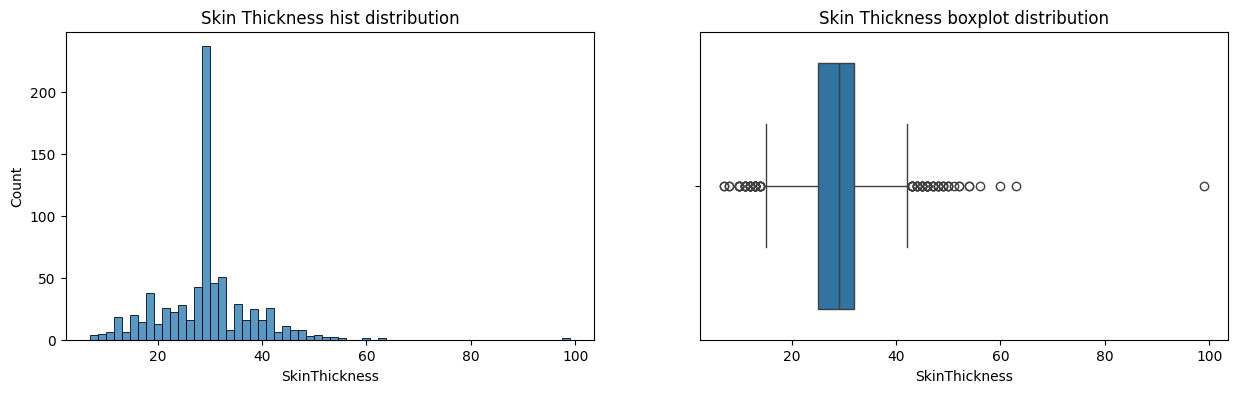

In [42]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
histplot = sns.histplot(data=diabetes_data, x='SkinThickness', ax=axes[0])
histplot.set_title('Skin Thickness hist distribution')
boxplot = sns.boxplot(data=diabetes_data, x='SkinThickness', ax=axes[1])
boxplot.set_title('Skin Thickness boxplot distribution');

In [44]:
def outlisers_iqr(data=pd.DataFrame, feature=str, log_scale=False, left=1.5, right=1.5):
    if log_scale:
        x = np.log(data[feature])
    else:
        x = data[feature]
        
    quantile_1, quantile_3 = x.quantile(0.25), x.quantile(0.75)
    iqr = quantile_3 - quantile_1
    lower_bound = quantile_1 - left * iqr
    upper_bound = quantile_3 + right * iqr
    outliers = data[(x<lower_bound) | (x>upper_bound)]
    cleaned = data[(x>=lower_bound) & (x<=upper_bound)]
    return outliers, cleaned

outliers, cleaned = outlisers_iqr(diabetes_data, 'SkinThickness')
print(f'Number of outliers for Skin Thickness: {outliers.shape[0]}')

Number of outliers for Skin Thickness: 87


Сколько выбросов найдёт классический метод z-отклонения в признаке SkinThickness?

In [45]:
def outliers_z_score(data, feature, log_scale=False, left=3, right=3):
    if log_scale:
        x = np.log(data[feature])
    else:
        x = data[feature]
        
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - left * sigma
    upper_bound = mu + right * sigma
    outliers = data[(x<lower_bound) | (x>upper_bound)]
    cleaned = data[(x>=lower_bound) & (x<=upper_bound)]
    return outliers, cleaned

outliers, cleaned = outliers_z_score(diabetes_data, 'SkinThickness')
print(f'Number of outliers for Skin Thickness: {outliers.shape[0]}')

Number of outliers for Skin Thickness: 4


На приведённой гистограмме показано распределение признака DiabetesPedigreeFunction. Такой вид распределения очень похож на логнормальный, и он заставляет задуматься о логарифмировании признака. Найдите сначала число выбросов в признаке DiabetesPedigreeFunction с помощью классического метода межквартильного размаха.

![diabetes_pedigree_function_hist](images/dpf_hist.png)

Затем найдите число выбросов в этом же признаке в логарифмическом масштабе (при логарифмировании единицу прибавлять не нужно!). Какова разница между двумя этими числами (вычтите из первого второе)?

In [48]:
outliers_standard, cleaned_standard = outlisers_iqr(diabetes_data, 'DiabetesPedigreeFunction')
print(f'Number of outliers using standard IQR: {outliers_standard.shape[0]}')

Number of outliers using standard IQR: 29


In [49]:
outliers_logscale, cleaned_logscale = outlisers_iqr(diabetes_data, 'DiabetesPedigreeFunction', log_scale=True)
print(f'Number of outliers using log-scale IQR: {outliers_logscale.shape[0]}')
print(f'Difference in outliers between log-scale and standard IQR: {outliers_standard.shape[0] - outliers_logscale.shape[0]}')

Number of outliers using log-scale IQR: 0
Difference in outliers between log-scale and standard IQR: 29
